# Logistic Regression (varying regularisation strength)

Varying the inverse of the regularisation strength (C=10 - 150000) always resulted in a predicted F1 score between 0.44 and 0.45 (60x cross-validation), therefore the initial value of C=100000 was kept for further models.

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from mask_to_submission import *
import pandas as pd

from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Helper functions

#Create prediction images using all the test images

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


In [4]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [5]:

# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X


In [6]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
# Extract patches from input images
def compute_best_f1_for_patch_size(patch_size):
    
    img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
    gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]
    
    # Linearize list of patches
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    
    # Compute features for each image patch
    foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch
    
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
        
    # train a logistic regression classifier
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.20, random_state=42)
    
    # we create an instance of the classifier and fit the data
    classifier = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
    classifier.fit(X_train, y_train)
    
    #Train-Test split
    k = 40
    f1 = cross_val_score(classifier, X, Y, cv=k, scoring="f1")

    return f1.mean()

In [7]:
#predict f1 scores for various patch sizes
patches = []
scores = []
for i in range(16,128,4):
    f1 = compute_best_f1_for_patch_size(i)
    patches.append(i)
    scores.append(f1)

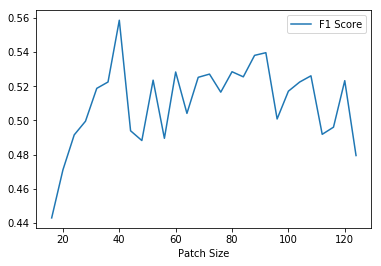

In [9]:
#plot regularisation vs predicted f1 score
d = {'Patch Size': patches, 'F1 Score': scores}
df = pd.DataFrame(d)
df.plot(x='Patch Size')